In [2]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import HTML
HTML('<style>.container { width:97% !important; }</style><style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>')

In [17]:
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.model_selection import train_test_split

from spektral.datasets import delaunay
from spektral.layers import GraphAttention, GlobalAvgPool
from spektral.utils import localpooling_filter


In [4]:
import load_data as ld
import utilities as ut
from sklearn.model_selection import StratifiedKFold
import numpy as np
import dataset_statistics as ds

In [19]:
n_bits = [2,3,4,5,6,8,10]
n_times = 5
name = "generate_graphs/489028_pos_neg_BALANCED(2864)"

In [1]:
acc_leukemia, loss_leukemia = run(name,n_bits,n_times)

# MOLECULES
## Cancer AID489028  (2864)

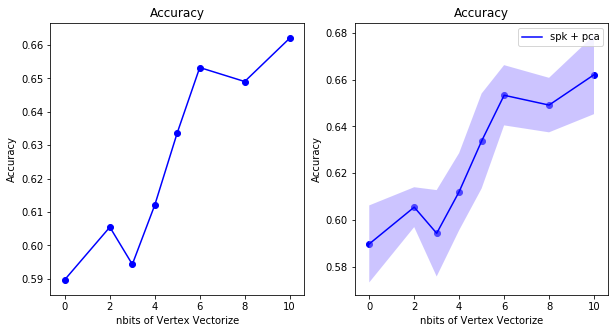

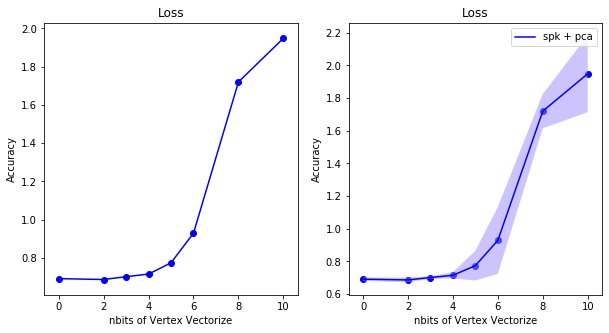

In [90]:
plot_nbits(metric = acc_cancer,
           n_bits = n_bits,
           text = "Accuracy")
plot_nbits(metric = loss_cancer,
           n_bits = n_bits,
           text = "Loss")

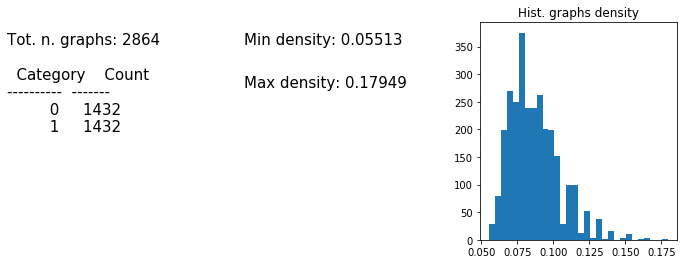

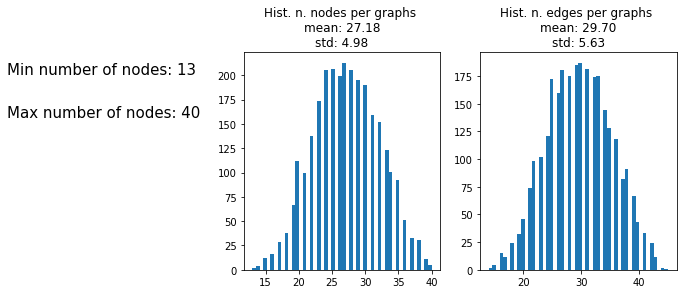

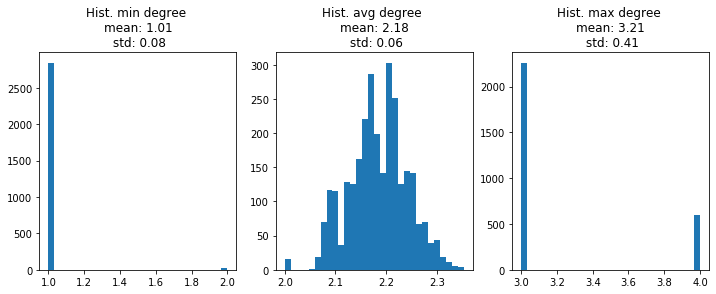

In [10]:
g,l = ld.load_data_pubchem("generate_graphs/489028_pos_neg_BALANCED(2864)")
ds.summary(g,l)

## Leukemia AID125

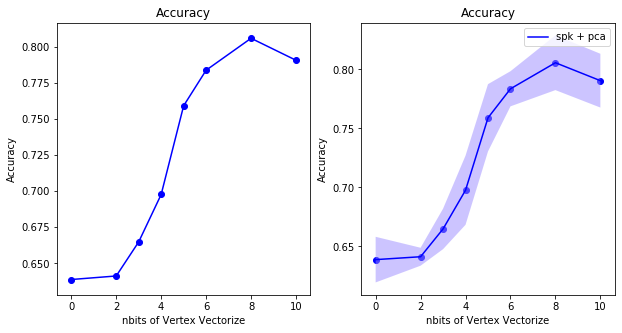

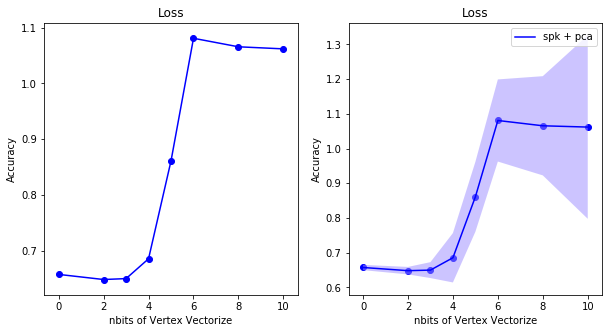

In [22]:
plot_nbits(metric = acc_leukemia,
           n_bits = n_bits,
           text = "Accuracy")
plot_nbits(metric = loss_leukemia,
           n_bits = n_bits,
           text = "Loss")

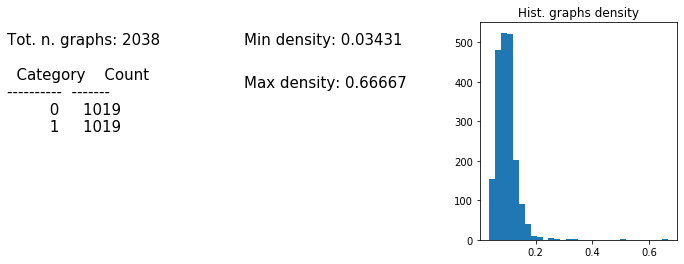

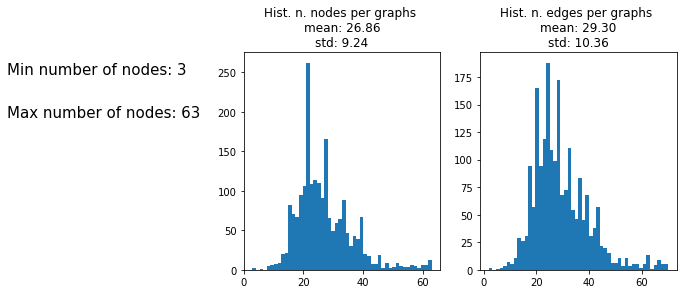

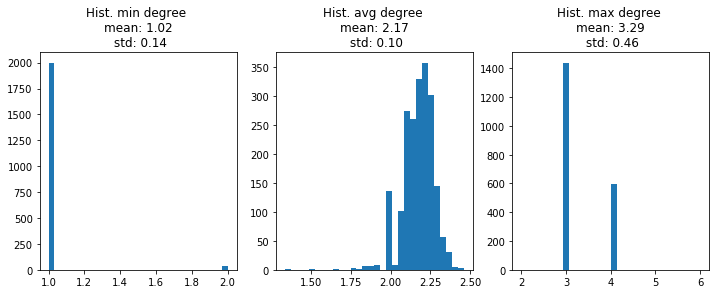

In [8]:
g,l = ld.load_data_pubchem("generate_graphs/125_pos_neg_BALANCED(2038)")
ds.summary(g,l)

# PROTEINS
## DHFR

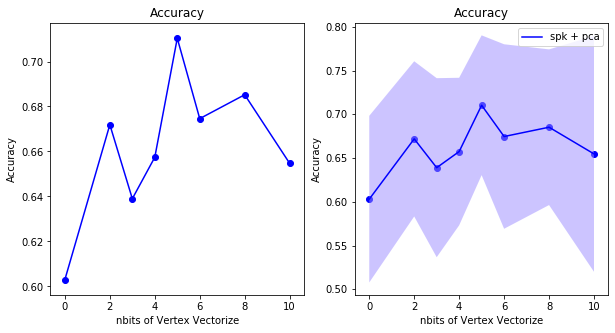

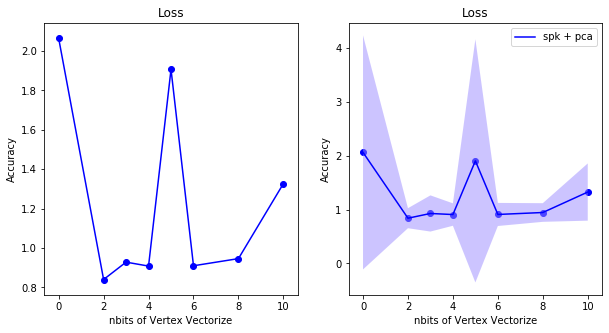

In [11]:
plot_nbits(metric = acc_DHFR,
           n_bits = n_bits,
           text = "Accuracy")
plot_nbits(metric = loss_DHFR,
           n_bits = n_bits,
           text = "Loss")

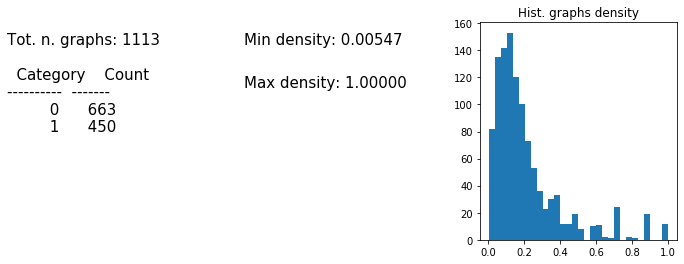

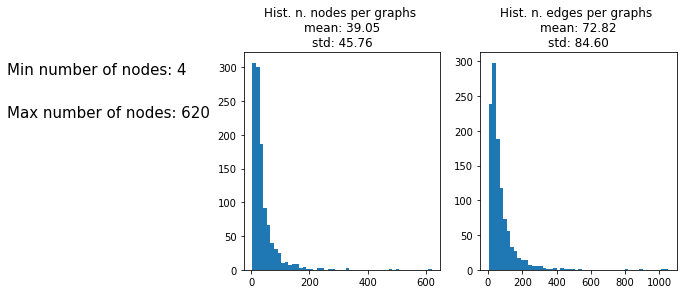

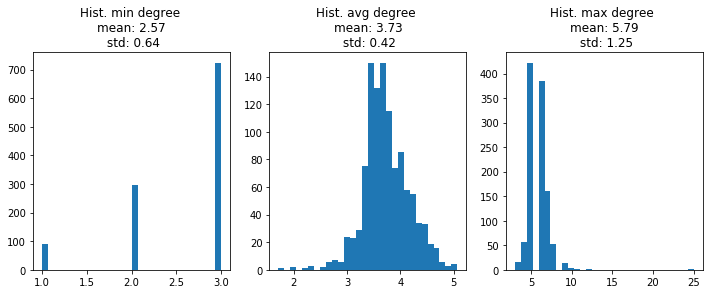

In [9]:
g,l = ld.load_data("PROTEINS")
ds.summary(g,l)

In [6]:
import matplotlib.pyplot as plt

def run(name,param,n_times):
    acc = []
    loss = []
    graphs,labels = ld.load_data_pubchem(name)
    grpahs = np.array(graphs)
    #graphs,labels = ld.load_data(name)
    func = [ut.degree, ut.clust_coefficient]
    graphs = ut.add_info_to_nodes(graphs,func,param=None)
    print("no Vectorize:")
    res_acc, res_loss = repeat_n_times(graphs,labels,n_times)
    acc.append(res_acc)
    loss.append(res_loss)
    for i in param:
        print("si Vectorize - n_bits = "+str(i))
        #graphs,labels = ld.load_data(name)
        graphs,labels = ld.load_data_pubchem(name)
        grpahs = np.array(graphs)
        
        func = [ut.degree, ut.clust_coefficient,ut.vec_vertex]
        graphs = ut.add_info_to_nodes(graphs,func,param=i)
        res_acc, res_loss = repeat_n_times(graphs,labels,n_times)
        acc.append(res_acc)
        loss.append(res_loss)
        
    return(acc,loss)

def repeat_n_times(graphs,labels,n_times):
    graphs = np.array(graphs)
    adj, x , _ = ut.from_nx_to_adj(graphs)
    kFold = StratifiedKFold(n_splits=n_times)
    r_acc = []
    r_loss = []
    c = 0
    for train, test in kFold.split(adj, labels):
        c = c +1
        print("\t fold:"+str(c))
        loss, acc = spk_train_test(adj[train],x[train], labels[train],adj[test],x[test], labels[test])
        r_acc.append(acc)
        r_loss.append(loss)
    return(r_acc,r_loss)

def spk_train_test(adj_train,x_train,labels_train,adj_test,x_test, labels_test):
    
    y_train = ut.from_np_to_one_hot(labels_train)
    y_test = ut.from_np_to_one_hot(labels_test)
    
    
    
    # Parameters
    N = x_train.shape[-2]           # Number of nodes in the graphs
    F = x_train.shape[-1]           # Original feature dimensionality
    n_classes = y_train.shape[-1]   # Number of classes
    l2_reg = 5e-4             # Regularization rate for l2
    learning_rate = 1e-3      # Learning rate for Adam
    epochs = 200              # Number of training epochs
    batch_size = 32           # Batch size
    es_patience = 25          # Patience fot early stopping



    # Preprocessing
    fltr_train = localpooling_filter(adj_train.copy())
    fltr_test = localpooling_filter(adj_test.copy())

    # Model definition
    X_in = Input(shape=(N, F))
    filter_in = Input((N, N))

    gc1 = GraphAttention(128, activation='relu', kernel_regularizer=l2(l2_reg))([X_in, filter_in])
    gc2 = GraphAttention(128, activation='relu', kernel_regularizer=l2(l2_reg))([gc1, filter_in])
    gc3 = GraphAttention(128, activation='relu', kernel_regularizer=l2(l2_reg))([gc2, filter_in])
    pool = GlobalAvgPool()(gc3)

    output = Dense(n_classes, activation='softmax')(pool)

    # Build model
    model = Model(inputs=[X_in, filter_in], outputs=output)
    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])



    # Callbacks
    es_callback = EarlyStopping(monitor='val_acc', patience=es_patience)

    # Train model
    model.fit([x_train, fltr_train],
              y_train,
              batch_size=batch_size,
              validation_split=0.1,
              epochs=epochs,
              verbose = 0,
              callbacks=[es_callback])

    # Evaluate model
    eval_results = model.evaluate([x_test, fltr_test],
                                  y_test,
                                  verbose = 0,
                                  batch_size=batch_size)
    
    return (eval_results[0],eval_results[1])


def  plot_nbits(metric,n_bits,text="Accuracy"):
    n_bits = [0] + n_bits
    mean = []
    std = []
    for i in metric:
        mean.append(np.mean(i))
        std.append(np.std(i))
    
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.title(text)
    plt.plot(n_bits,mean, label='spk + pca',color='b')
    plt.scatter(n_bits,mean,color='b')
    plt.xlabel("nbits of Vertex Vectorize")
    plt.ylabel("Accuracy")


    plt.subplot(122)
    plt.title(text)
    plt.plot(n_bits,mean, label='spk + pca',color='b')
    plt.scatter(n_bits,mean,color='b')
    low = [mean[i]-std[i] for i in range(0,len(mean))] 
    upp = [mean[i]+std[i] for i in range(0,len(mean))]
    plt.fill_between(n_bits,low,upp, facecolor='#9B8BFF', alpha=0.5)
    plt.xlabel("nbits of Vertex Vectorize")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()



